# Movie Review Sentiment Analysis using LSTM

## Project Steps:
> * #### Importing important depenedencies
> * #### EDA
> * #### Text Preprocessing
> * #### Model Building
> * #### Evaluation
> * #### Summary
---

### Importing important dependencies

In [1]:
# Main libraries
import numpy as np
import pandas as pd
pd.set_option('max_colwidth',400)
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
%matplotlib inline
from bs4 import BeautifulSoup
import re,string,unicodedata

# ML libraries (Preprocessing, models..)
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# NLTK 
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

# CNN, LSTM and Embedding 
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.preprocessing.text import Tokenizer
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification , AutoTokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, ZeroPadding1D, Add, Flatten, Dot, Concatenate, Lambda
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D, TimeDistributed, Attention
from keras.layers import InputSpec, Layer
from keras.models import Model, load_model
from keras.optimizers import Adam,Adagrad
from tensorflow_addons.optimizers import AdamW
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

## Text mining and EDA

In [2]:
# Selecting a subset of data to be faster in demonstration
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv',encoding="utf-8")
print('Dataset: '+ str(len(df)))
df.head(10)

Dataset: 50000


review  \
0  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regard...   
1  A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the ref...   
2  I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof...   
3  Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Paren...   
4  Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action t...   
5  Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more l...   
6  I sure would like to see a resurrection of a up dated Seahunt series with the tech they have today it would bring back the kid excitement in me.I grew up on black and white TV and Seahunt with Gunsmoke were my hero's every week.You have my vote for a comeback of a new sea hunt.We need a change of pace in TV and this would work for a world of under water adventure.Oh by the way thank you for an...   
7  This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performance...   
8  Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in t...   
9                                                                                                                                                                                                                                 If you like original gut wrenching laughter you will like this movie. If you are young or old then you will lo

In [3]:
# First split: Train (80%) and the rest (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# Second split: Test (50%) and Validation (50%) from the rest
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

<AxesSubplot:xlabel='sentiment'>

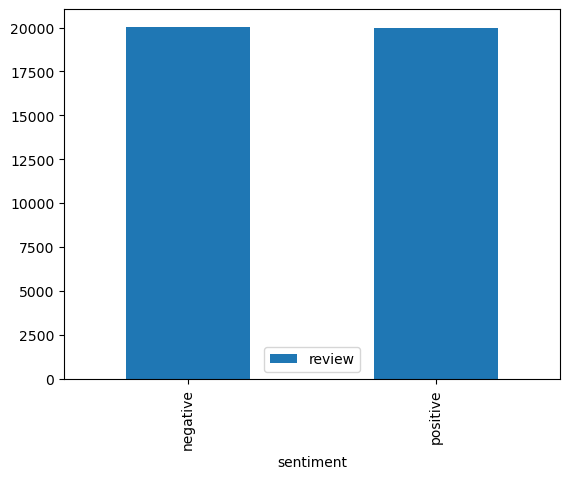

In [4]:
# The distribution of sentiments
train_df.groupby('sentiment').count().plot(kind='bar')

This means that the no. of positive reviews is equal to the no. of negative reviews in the dataset. This is a good thing since it means our dataset is not skewed.

<AxesSubplot:>

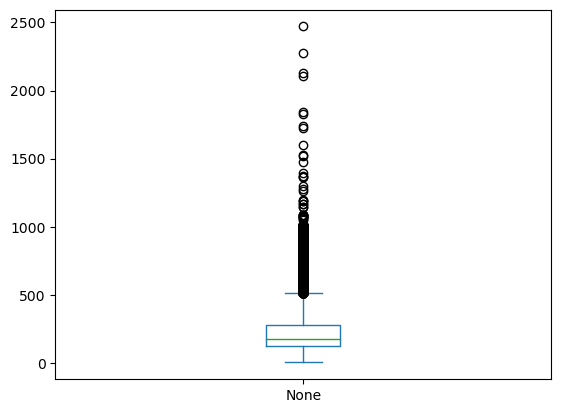

In [5]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in train_df['review']])

# The distribution of review text lengths
review_len.plot(kind='box')

Now, let us visualize how long our sentences are in the training data

<AxesSubplot:ylabel='Count'>

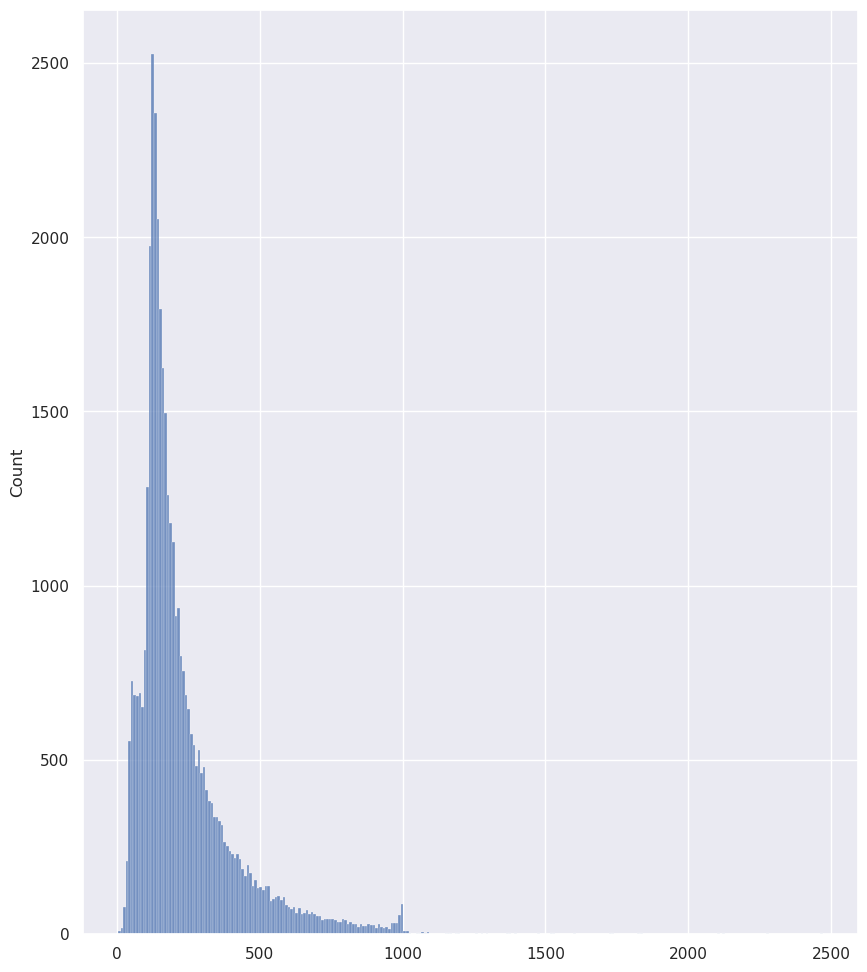

In [6]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)

plt.figure(figsize = (10,12))
sns.histplot(review_len)

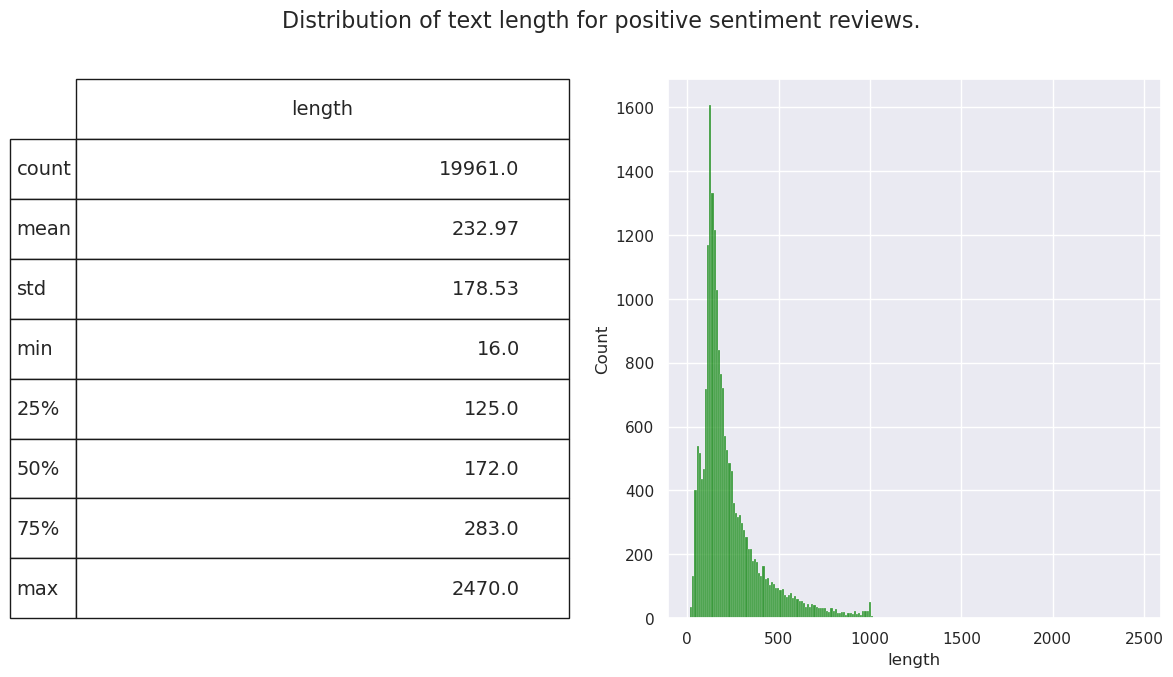

In [7]:
fig = plt.figure(figsize=(14,7))
train_df['length'] = train_df.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(train_df[train_df['sentiment']=="positive"]['length'], ax=ax1,color='green')
describe = train_df.length[train_df.sentiment=="positive"].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

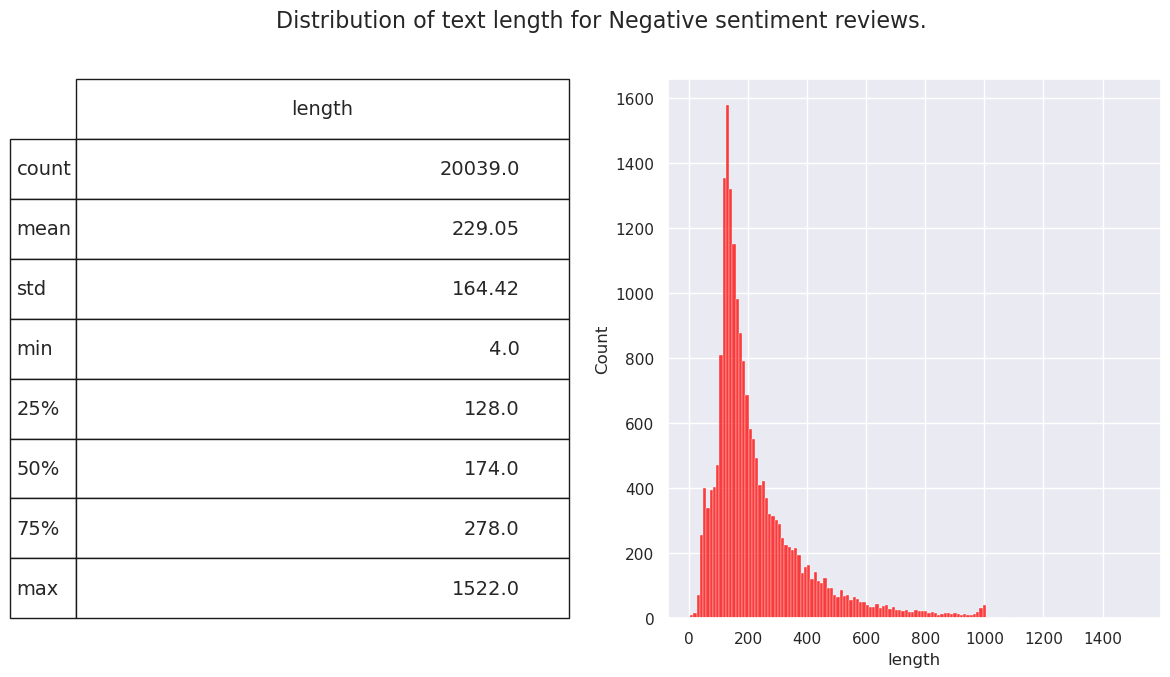

In [8]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(train_df[train_df['sentiment']=="negative"]['length'], ax=ax1,color='red')
describe = train_df.length[train_df.sentiment=="negative"].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment reviews.', fontsize=16)

plt.show()

### WORDCLOUD FOR NEGATIVE TEXT (LABEL - 0)

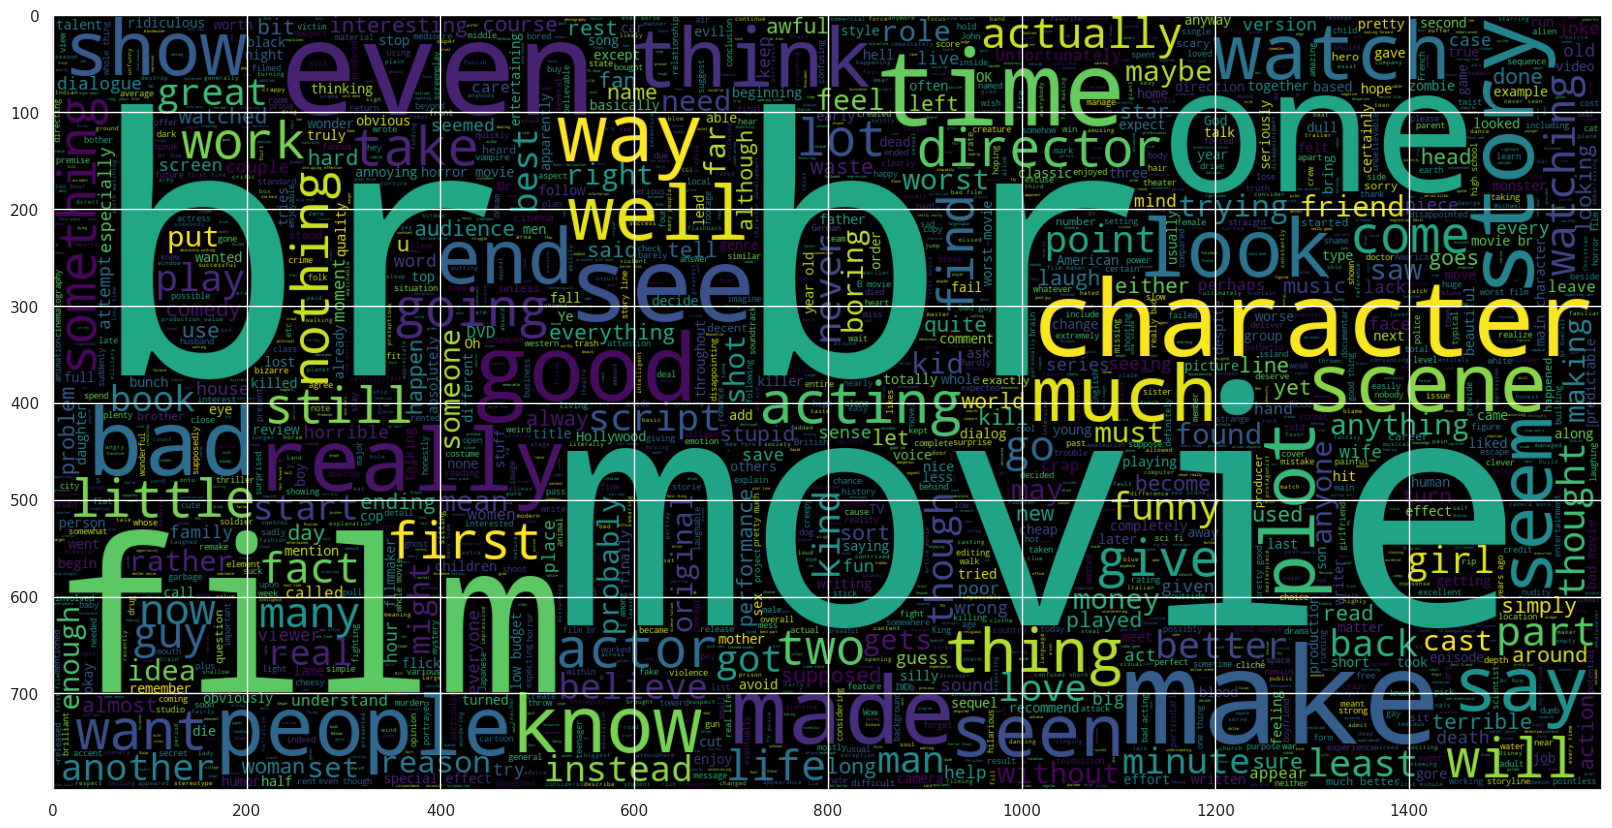

In [9]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(train_df[train_df.sentiment == "negative"].review))
plt.imshow(wc , interpolation = 'bilinear')

### WORDCLOUD FOR POSITIVE TEXT (LABEL - 1)


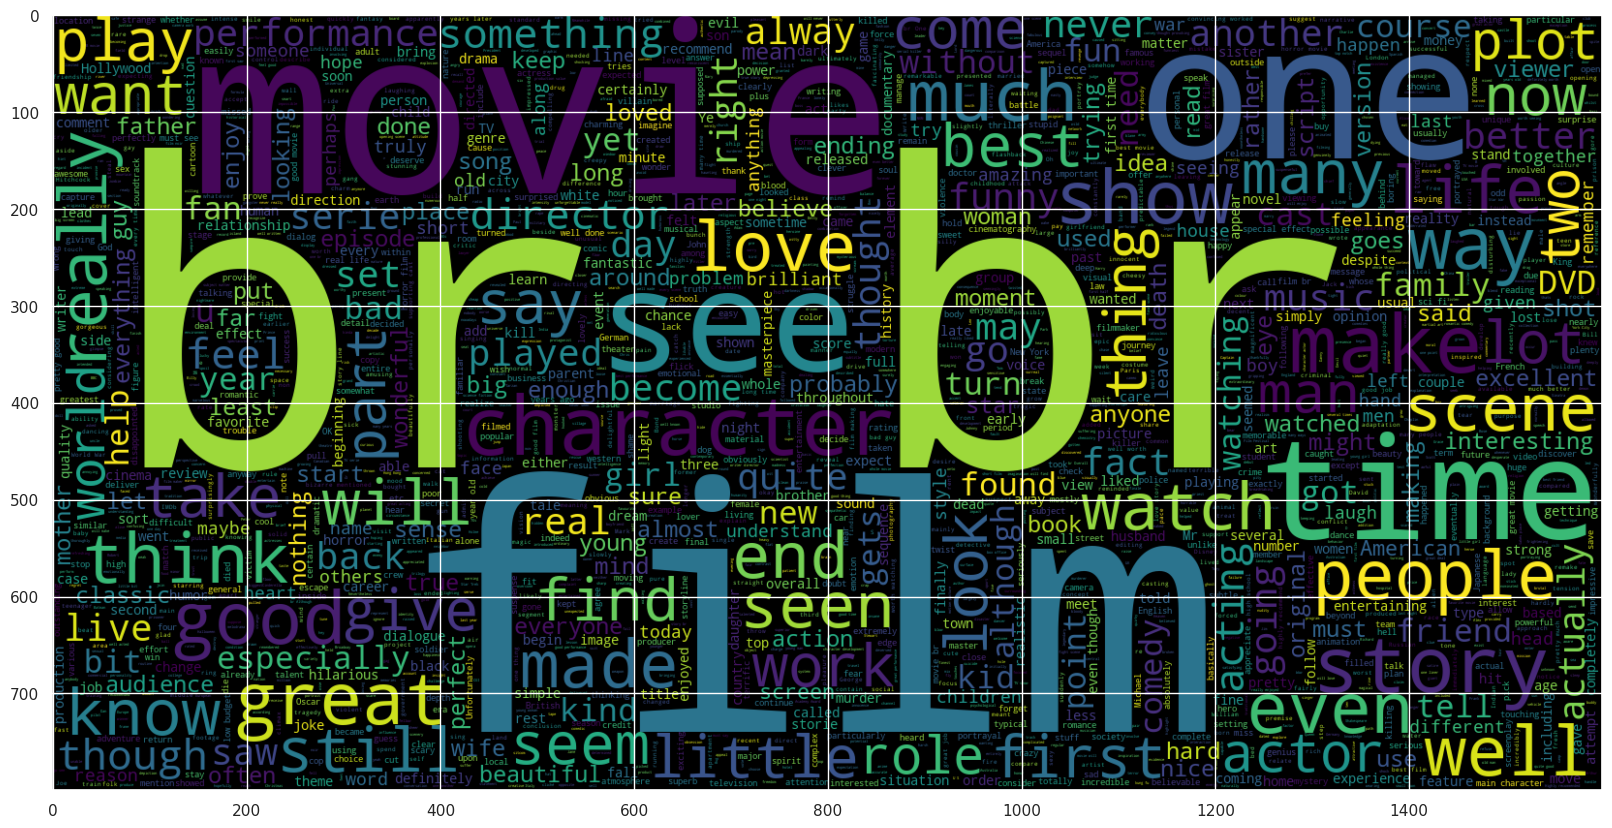

In [10]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(train_df[train_df.sentiment == "positive"].review))
plt.imshow(wc , interpolation = 'bilinear')

---
## Text Preprocessing

Text preprocessing is an essential step in natural language processing (NLP) and machine learning projects, including sentiment analysis. Here are some of the typical text preprocessing steps for a sentiment analysis NLP project:

* `Text Cleaning`: Remove unnecessary characters, such as punctuation, special characters, numbers, and stop words (common words that don't carry much meaning, such as "the," "a," "and," etc.)

* `Lowercasing`: Convert all the words to lowercase to treat different cases of the same word as the same (e.g., "good" and "Good").

* `Tokenization`: Split the text into individual words or phrases (tokens).

* `Stemming/Lemmatization`: Reduce words to their base or root form to normalize the text. Stemming removes the suffixes from words, while lemmatization reduces words to their base form based on their part of speech.

* `Parts of Speech Tagging`: Identify the part of speech of each word (noun, verb, adjective, etc.) to help determine the meaning and context of the sentence.

* `Sentiment lexicon-based feature extraction`: Assign a sentiment score to each token based on a sentiment lexicon (a dictionary of words and their sentiment polarity).

* `Feature Encoding`: Convert text data into numerical representations that machine learning algorithms can understand, such as one-hot encoding, TF-IDF, or word embedding.

* `Feature Selection`: Select the most relevant features to reduce the dimensionality of the data and improve the model's performance.

In [11]:
# Turning all text to lowercase
train_df['review'] = train_df['review'].str.lower()
val_df['review'] = val_df['review'].str.lower()
test_df['review'] = test_df['review'].str.lower()
train_df.head()

review  \
39087  that's what i kept asking myself during the many fights, screaming matches, swearing and general mayhem that permeate the 84 minutes. the comparisons also stand up when you think of the one-dimensional characters, who have so little depth that it is virtually impossible to care what happens to them. they are just badly written cyphers for the director to hang his multicultural beliefs on, a to...   
30893  i did not watch the entire movie. i could not watch the entire movie. i stopped the dvd after watching for half an hour and i suggest anyone thinking of watching themselves it stop themselves before taking the disc out of the case.<br /><br />i like mafia movies both tragic and comic but corky romano can only be described as a tragic attempt at a mafia comedy.<br /><br />the problem is corky r...   
45278  a touching love story reminiscent of in the mood for love'. drawing heavily on chinese poetry and how this is used by eastern people to communicate feelings to each other, the story focuses on a schoolteacher who wants so much to be a model teacher as well as a good husband and father. a senior student is very attracted to him. as the story unfolds we see the emotions below the surface in his...   
16398  this latter-day fulci schlocker is a totally abysmal concoction dealing with an incurable gambler (brett halsey) who decides bluebeard-style to pay off his ever-rising debts by seducing some of the ugliest bitches you will ever lay your eyes on and who just happen to be wealthy widows! the fulci-penned script also contrives to incorporate a few blackly comedic elements - which only result in s...   
13653  first of all, i firmly believe that norwegian movies are continually getting better. from the tedious emotional films of the 70's and 80's, movies from this place actually started to contain a bit of humour. imagine.. actual comedies were made! movies were actually starting to get entertaining and funny, as opposed to long, dark, depressing and boring.<br /><br />during the 90's and 00's sever...   

      sentiment  length  
39087  negative     400  
30893  negative     283  
45278  positive      93  
16398  negative     174  
13653  negative     306

In [12]:
# Removing punctuation
exclude = set(string.punctuation) 

def remove_punctuation(x): 
    try: 
        x = ''.join(ch for ch in x if ch not in exclude) 
    except: 
        pass 
    return x 

train_df['review'] = train_df['review'].apply(remove_punctuation)
val_df['review'] = val_df['review'].apply(remove_punctuation)
test_df['review'] = test_df['review'].apply(remove_punctuation)
train_df.head()

review  \
39087  thats what i kept asking myself during the many fights screaming matches swearing and general mayhem that permeate the 84 minutes the comparisons also stand up when you think of the onedimensional characters who have so little depth that it is virtually impossible to care what happens to them they are just badly written cyphers for the director to hang his multicultural beliefs on a topic that...   
30893  i did not watch the entire movie i could not watch the entire movie i stopped the dvd after watching for half an hour and i suggest anyone thinking of watching themselves it stop themselves before taking the disc out of the casebr br i like mafia movies both tragic and comic but corky romano can only be described as a tragic attempt at a mafia comedybr br the problem is corky romano simply tri...   
45278  a touching love story reminiscent of in the mood for love drawing heavily on chinese poetry and how this is used by eastern people to communicate feelings to each other the story focuses on a schoolteacher who wants so much to be a model teacher as well as a good husband and father a senior student is very attracted to him as the story unfolds we see the emotions below the surface in his 20 y...   
16398  this latterday fulci schlocker is a totally abysmal concoction dealing with an incurable gambler brett halsey who decides bluebeardstyle to pay off his everrising debts by seducing some of the ugliest bitches you will ever lay your eyes on and who just happen to be wealthy widows the fulcipenned script also contrives to incorporate a few blackly comedic elements  which only result in some unfu...   
13653  first of all i firmly believe that norwegian movies are continually getting better from the tedious emotional films of the 70s and 80s movies from this place actually started to contain a bit of humour imagine actual comedies were made movies were actually starting to get entertaining and funny as opposed to long dark depressing and boringbr br during the 90s and 00s several really great movie...   

      sentiment  length  
39087  negative     400  
30893  negative     283  
45278  positive      93  
16398  negative     174  
13653  negative     306

In [13]:
# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
# Apply function on review column
train_df['review'] = train_df['review'].apply(denoise_text)
val_df['review'] = val_df['review'].apply(denoise_text)
test_df['review'] = test_df['review'].apply(denoise_text)
train_df.head()

review  \
39087  thats what i kept asking myself during the many fights screaming matches swearing and general mayhem that permeate the 84 minutes the comparisons also stand up when you think of the onedimensional characters who have so little depth that it is virtually impossible to care what happens to them they are just badly written cyphers for the director to hang his multicultural beliefs on a topic that...   
30893  i did not watch the entire movie i could not watch the entire movie i stopped the dvd after watching for half an hour and i suggest anyone thinking of watching themselves it stop themselves before taking the disc out of the casebr br i like mafia movies both tragic and comic but corky romano can only be described as a tragic attempt at a mafia comedybr br the problem is corky romano simply tri...   
45278  a touching love story reminiscent of in the mood for love drawing heavily on chinese poetry and how this is used by eastern people to communicate feelings to each other the story focuses on a schoolteacher who wants so much to be a model teacher as well as a good husband and father a senior student is very attracted to him as the story unfolds we see the emotions below the surface in his 20 y...   
16398  this latterday fulci schlocker is a totally abysmal concoction dealing with an incurable gambler brett halsey who decides bluebeardstyle to pay off his everrising debts by seducing some of the ugliest bitches you will ever lay your eyes on and who just happen to be wealthy widows the fulcipenned script also contrives to incorporate a few blackly comedic elements  which only result in some unfu...   
13653  first of all i firmly believe that norwegian movies are continually getting better from the tedious emotional films of the 70s and 80s movies from this place actually started to contain a bit of humour imagine actual comedies were made movies were actually starting to get entertaining and funny as opposed to long dark depressing and boringbr br during the 90s and 00s several really great movie...   

      sentiment  length  
39087  negative     400  
30893  negative     283  
45278  positive      93  
16398  negative     174  
13653  negative     306

In [14]:
# set stopwords to english
stop=set(stopwords.words('english'))
stopword_list=nltk.corpus.stopwords.words('english')
print(stop)

# Create an instance of the TweetTokenizer class
# Tokenization of text
tokenizer=TweetTokenizer()


# removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
stop = stopwords.words('english')

train_df['review'] = train_df['review'].apply(remove_stopwords)
val_df['review'] = val_df['review'].apply(remove_stopwords)
test_df['review'] = test_df['review'].apply(remove_stopwords)
train_df.head()

{'he', 'what', 'these', 'same', 'couldn', "you'll", 'didn', 're', 'itself', 'so', 'after', 'a', 'some', 'should', 'shan', 'yours', 'having', 'this', "shan't", 'yourself', 'wouldn', 'too', 'doesn', 'ours', 'with', 'll', "isn't", 'by', 'no', 'most', 'where', "hadn't", 'himself', 'her', 'theirs', "shouldn't", 'off', 'herself', 'other', 'm', 'or', 'while', 'each', 'ma', 'did', 'out', 'own', 'all', 'again', "mustn't", 'hers', 's', "doesn't", 'than', 'have', 'for', 'your', "it's", 'y', 'it', 'to', 'being', 'be', 'when', 'and', 'myself', 'mightn', 'between', "wasn't", 'because', 'whom', "mightn't", 'd', 'is', "couldn't", "aren't", 'them', 'does', 'such', 'my', 'if', 'our', 'further', 'haven', 'they', 'am', 'who', 'above', 'only', 'can', 'mustn', 'below', 'ourselves', 'isn', 'in', 'through', 'at', 'hadn', 'wasn', 'about', 'doing', 'of', 'the', 'will', 'an', 'against', 'but', "you're", 'just', 'was', 'before', "won't", 'me', 'any', 'up', "you'd", 'were', 'now', 'been', 'weren', 'yourselves', "n

review  \
39087  thats kept asking many fights screaming matches swearing general mayhem permeate 84 minutes comparisons also stand think onedimensional characters little depth virtually impossible care happens badly written cyphers director hang multicultural beliefs topic done much better dramas tv cinemabr br must confess im really one spotting bad performances film must said nichola burley heroines slutty ...   
30893  watch entire movie could watch entire movie stopped dvd watching half hour suggest anyone thinking watching stop taking disc casebr br like mafia movies tragic comic corky romano described tragic attempt mafia comedybr br problem corky romano simply tries hard get audience laugh plot seems excuse moving chris kattan corky one scene another corky completely overplayed lacks subtlety credulity s...   
45278                                                                               touching love story reminiscent  mood love drawing heavily chinese poetry used eastern people communicate feelings story focuses schoolteacher wants much model teacher well good husband father senior student attracted story unfolds see emotions surface 20 year marriage grapples moral dilemmas face beautiful moving story   
16398  latterday fulci schlocker totally abysmal concoction dealing incurable gambler brett halsey decides bluebeardstyle pay everrising debts seducing ugliest bitches ever lay eyes happen wealthy widows fulcipenned script also contrives incorporate blackly comedic elements result unfunny business involving corpse wont stay put opera singer victim wont stop singing etc mention doppelganger theme stra...   
13653  first firmly believe norwegian movies continually getting better tedious emotional films 70s 80s movies place actually started contain bit humour imagine actual comedies made movies actually starting get entertaining funny opposed long dark depressing boringbr br 90s 00s several really great movies made new generation filmmakers movie movie praised critics played loads money became normbr br c...   

      sentiment  length  
39087  negative     400  
30893  negative     283  
45278  positive      93  
16398  negative     174  
13653  negative     306

### Classical Models with TF-IDF, SVM, OneVsRest Classifer

In [15]:
# Create an instance of the TfidfVectorizer class with n-grams of size 1 and 2, 
# and use the TweetTokenizer to tokenize the text
vectorizer = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
# Combine the text from the train and test dataframes into a list
full_text = list(train_df['review'].values) + list(test_df['review'].values)
# Fit the vectorizer on the combined text
vectorizer.fit(full_text)
# Use the fitted vectorizer to transform the text in the train, test and validation dataframe into a sparse matrix of TF-IDF values
train_vectorized = vectorizer.transform(train_df['review'])
test_vectorized = vectorizer.transform(test_df['review'])
val_vectorized = vectorizer.transform(val_df['review'])

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [16]:
y = train_df['sentiment']

### Using OneVsRestClassifier and Logistic Regression

In [17]:
logreg = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
ovr = OneVsRestClassifier(logreg)

In [18]:
%%time
ovr.fit(train_vectorized, y)

CPU times: user 12.1 s, sys: 2.96 s, total: 15 s
Wall time: 11.6 s


OneVsRestClassifier(estimator=LogisticRegression(C=1, max_iter=500,
                                                 random_state=42))

In [19]:
scores = cross_val_score(ovr, train_vectorized, y, scoring='accuracy', n_jobs=-1, cv=3)
print('Cross-validation mean accuracy {0:.2f}%, std {1:.2f}.'.format(np.mean(scores) * 100, np.std(scores) * 100))

Cross-validation mean accuracy 50.10%, std 0.00.


### Using SVM Model

In [20]:
%%time
svc = LinearSVC(dual=False)
scores = cross_val_score(svc, train_vectorized, y, scoring='accuracy', n_jobs=-1, cv=3)
print('Cross-validation mean accuracy {0:.2f}%, std {1:.2f}.'.format(np.mean(scores) * 100, np.std(scores) * 100))

Cross-validation mean accuracy 50.10%, std 0.00.
CPU times: user 135 ms, sys: 15 ms, total: 150 ms
Wall time: 2.19 s


In [21]:
ovr.fit(train_vectorized, y);
svc.fit(train_vectorized, y);

### Changing the classifier by a LSTM and EMBEDDING model

In [22]:
# Create an instance of the Tokenizer class with options to lowercase the text and remove all filters
tk = Tokenizer(lower = True, filters='')
tk.fit_on_texts(full_text)

In [23]:
# Use the fitted tokenizer to convert the text in the train dataframe into a sequence of integer indexes
train_tokenized = tk.texts_to_sequences(train_df['review'])
# Use the fitted tokenizer to convert the text in the test dataframe into a sequence of integer indexes
test_tokenized = tk.texts_to_sequences(test_df['review'])

In [24]:
max_len = 512
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

We have used the `texts_to_sequences` method of the fitted tokenizer to convert the text in the `train_df['text']` and `test_df['text']` columns into sequences of `integer indexes`. Each unique word in the text is assigned a unique integer index based on its frequency in the text. The resulting sequences are then stored in the `train_tokenized` and `test_tokenized` variables, respectively. These integer sequences can be used as input to machine learning algorithms that require numerical input.

In [25]:
# Define the path to the pre-trained word embedding file
embedding_path = "/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"
# Set the size of the word embeddings to 300
embed_size = 300
# Set the maximum number of features to 30,000
max_features = 30000

We have set up the parameters for the pre-trained word embeddings that will be used to initialize the embedding layer in the neural network. The `embedding_path` variable specifies the path to the file containing the pre-trained word embeddings. The `embed_size` variable specifies the size of the word embeddings, which is set to 300. The `max_features` variable specifies the maximum number of features (i.e. words) that will be included in the vocabulary, which is set to `30,000`. These parameters will be used later when defining the embedding layer in the neural network.

In [26]:
# This function returns a tuple with the word and its corresponding coefficients as a numpy array
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
# Load the pre-trained embeddings file and create a dictionary of word vectors
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))
# Get the index of each word in the tokenizer
word_index = tk.word_index
# Set the number of words to be used as the minimum between the maximum features allowed and the number of words in the tokenizer
nb_words = min(max_features, len(word_index))
# Initialize an embedding matrix of zeros with shape (nb_words + 1, embed_size)
embedding_matrix = np.zeros((nb_words + 1, embed_size))
# Iterate over each word in the tokenizer and its index
for word, i in word_index.items():
    # If the index of the word is greater than or equal to the maximum features allowed, skip it
    if i >= max_features: continue
    # Get the embedding vector of the word from the pre-trained embeddings dictionary
    embedding_vector = embedding_index.get(word)
    # If the embedding vector is not None, add it to the embedding matrix at the index of the word in the tokenizer
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

### Using OneHotEncoder

In [27]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y.values.reshape(-1, 1))

### Model Arcitecture 1: GRU + CONV + LSTM

In [28]:
# Defining the model
def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model_1.h5"
    
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
    
    
    inp = Input(shape = (max_len,))
    x = Embedding(30001, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy",
                  optimizer = AdamW(lr = lr, weight_decay = lr_d),
                  metrics = ["accuracy"])
    history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 30, validation_split=0.1,
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [29]:
model1 = build_model1(lr = 1e-3,
                      lr_d = 1e-10,
                      units = 64,
                      spatial_dr = 0.3,
                      kernel_size1=3,
                      kernel_size2=2,
                      dense_units=32,
                      dr=0.2,
                      conv_size=64)

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
282/282 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.8090
Epoch 1: val_loss improved from inf to 0.32307, saving model to best_model_1.h5
282/282 [==============================] - 53s 125ms/step - loss: 0.4280 - accuracy: 0.8090 - val_loss: 0.3231 - val_accuracy: 0.8823
Epoch 2/30
282/282 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8678
Epoch 2: val_loss improved from 0.32307 to 0.26183, saving model to best_model_1.h5
282/282 [==============================] - 35s 123ms/step - loss: 0.3199 - accuracy: 0.8678 - val_loss: 0.2618 - val_accuracy: 0.8888
Epoch 3/30
282/282 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.8826
Epoch 3: val_loss did not improve from 0.26183
282/282 [==============================] - 35s 125ms/step - loss: 0.2899 - accuracy: 0.8826 - val_loss: 0.2958 - val_accuracy: 0.8677
Epoch 4/30
282/282 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.8914
Epo

In [30]:
model2 = build_model1(lr = 1e-3,
                      lr_d = 1e-10,
                      units = 128,
                      spatial_dr = 0.5,
                      kernel_size1=3,
                      kernel_size2=2,
                      dense_units=64,
                      dr=0.3,
                      conv_size=64)

Epoch 1/30
282/282 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.7857
Epoch 1: val_loss improved from inf to 0.32087, saving model to best_model_1.h5
282/282 [==============================] - 63s 204ms/step - loss: 0.4701 - accuracy: 0.7857 - val_loss: 0.3209 - val_accuracy: 0.8725
Epoch 2/30
282/282 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8520
Epoch 2: val_loss did not improve from 0.32087
282/282 [==============================] - 55s 195ms/step - loss: 0.3508 - accuracy: 0.8520 - val_loss: 0.3534 - val_accuracy: 0.8322
Epoch 3/30
282/282 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8689
Epoch 3: val_loss improved from 0.32087 to 0.25404, saving model to best_model_1.h5
282/282 [==============================] - 56s 198ms/step - loss: 0.3177 - accuracy: 0.8689 - val_loss: 0.2540 - val_accuracy: 0.8905
Epoch 4/30
282/282 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.8733
Epo

### Model Architecture 2: GRU + CONV + LSTM + ATTENTION Mechanism

In [31]:
def build_model2(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model_2.h5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(30001, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
    
    
    x_conv3 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x_conv3)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv3)
    
    x_conv4 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool2_lstm = GlobalAveragePooling1D()(x_conv4)
    max_pool2_lstm = GlobalMaxPooling1D()(x_conv4)
    
    x_conv5 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x_conv5)
    max_pool3_lstm = GlobalMaxPooling1D()(x_conv5)
    
    # Attention Mechanism
    attention_gru = Attention(max_len)([x_gru, x_gru])
    attention_lstm = Attention(max_len)([x_lstm, x_lstm])
    
    # Flatten layers for attention layers
    attention_gru = Flatten()(attention_gru)
    attention_lstm = Flatten()(attention_lstm)
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool2_lstm, max_pool2_lstm,
                    avg_pool2_lstm, max_pool3_lstm, attention_gru, attention_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy",
                  optimizer = AdamW(lr = lr, weight_decay = lr_d),
                  metrics = ["accuracy"])
    history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 20, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [32]:
model3 = build_model2(lr = 1e-4,
                      lr_d = 1e-7,
                      units = 64,
                      spatial_dr = 0.5,
                      kernel_size1=4,
                      kernel_size2=3,
                      dense_units=32,
                      dr=0.2,
                      conv_size=64)

Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.7207
Epoch 1: val_loss improved from inf to 0.55445, saving model to best_model_2.h5
282/282 [==============================] - 67s 217ms/step - loss: 0.5803 - accuracy: 0.7207 - val_loss: 0.5545 - val_accuracy: 0.7830
Epoch 2/20
282/282 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.7945
Epoch 2: val_loss improved from 0.55445 to 0.46421, saving model to best_model_2.h5
282/282 [==============================] - 60s 213ms/step - loss: 0.4722 - accuracy: 0.7945 - val_loss: 0.4642 - val_accuracy: 0.7760
Epoch 3/20
282/282 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.8092
Epoch 3: val_loss improved from 0.46421 to 0.33532, saving model to best_model_2.h5
282/282 [==============================] - 60s 212ms/step - loss: 0.4428 - accuracy: 0.8092 - val_loss: 0.3353 - val_accuracy: 0.8685
Epoch 4/20
282/282 [==============================] - ETA: 0s 

In [33]:
model4 = build_model2(lr = 1e-3,
                      lr_d = 1e-5,
                      units = 64,
                      spatial_dr = 0.5,
                      kernel_size1=3,
                      kernel_size2=3,
                      dense_units=64,
                      dr=0.3,
                      conv_size=64)

Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.7868
Epoch 1: val_loss improved from inf to 0.45773, saving model to best_model_2.h5
282/282 [==============================] - 67s 220ms/step - loss: 0.4660 - accuracy: 0.7868 - val_loss: 0.4577 - val_accuracy: 0.7958
Epoch 2/20
282/282 [==============================] - ETA: 0s - loss: 0.3545 - accuracy: 0.8512
Epoch 2: val_loss improved from 0.45773 to 0.31569, saving model to best_model_2.h5
282/282 [==============================] - 60s 214ms/step - loss: 0.3545 - accuracy: 0.8512 - val_loss: 0.3157 - val_accuracy: 0.8665
Epoch 3/20
282/282 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.8616
Epoch 3: val_loss improved from 0.31569 to 0.25602, saving model to best_model_2.h5
282/282 [==============================] - 60s 214ms/step - loss: 0.3271 - accuracy: 0.8616 - val_loss: 0.2560 - val_accuracy: 0.8935
Epoch 4/20
282/282 [==============================] - ETA: 0s 

In [34]:
model5 = build_model2(lr = 1e-3,
                      lr_d = 1e-7,
                      units = 64,
                      spatial_dr = 0.3,
                      kernel_size1=3,
                      kernel_size2=3,
                      dense_units=64,
                      dr=0.4,
                      conv_size=64)

Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8044
Epoch 1: val_loss improved from inf to 0.52373, saving model to best_model_2.h5
282/282 [==============================] - 67s 218ms/step - loss: 0.4480 - accuracy: 0.8044 - val_loss: 0.5237 - val_accuracy: 0.7122
Epoch 2/20
282/282 [==============================] - ETA: 0s - loss: 0.3303 - accuracy: 0.8663
Epoch 2: val_loss improved from 0.52373 to 0.33264, saving model to best_model_2.h5
282/282 [==============================] - 60s 214ms/step - loss: 0.3303 - accuracy: 0.8663 - val_loss: 0.3326 - val_accuracy: 0.8428
Epoch 3/20
282/282 [==============================] - ETA: 0s - loss: 0.3063 - accuracy: 0.8771
Epoch 3: val_loss improved from 0.33264 to 0.25297, saving model to best_model_2.h5
282/282 [==============================] - 60s 213ms/step - loss: 0.3063 - accuracy: 0.8771 - val_loss: 0.2530 - val_accuracy: 0.8935
Epoch 4/20
282/282 [==============================] - ETA: 0s 

In [47]:
pred1 = model1.predict(X_test, batch_size = 1024, verbose = 1)
pred = pred1
pred2 = model2.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred2
pred3 = model3.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred3
pred4 = model4.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred4
pred5 = model5.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred5

5/5 [==============================] - 2s 402ms/step


### Testing our Model

In [65]:
# Load the best model based on the saved weights
best_model_review = load_model("best_model_1.h5")

# Make predictions on the test data
y_pred_prob = best_model_review.predict(X_test)

# Convert the probabilities to binary classes (0 or 1) based on a threshold (e.g., 0.5)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Convert the binary array to a single array representing the predicted sentiment for each review
predicted_sentiments = []
for i in range(len(y_pred_class)):
    if y_pred_class[i][0] == 1:
        predicted_sentiments.append("Negative")
    else:
        predicted_sentiments.append("Positive")

# Printing each review along with its predicted sentiment
print("------------------------------------------------------")
print("|  No.  |               Review               |  Sentiment |")
print("------------------------------------------------------")
for i, (review, sentiment) in enumerate(zip(test_df['review'], predicted_sentiments), 1):
    print(f"|  {str(i).ljust(5)}| {review.ljust(35)}\n\n| {sentiment.ljust(10)}|\n\n")
print("------------------------------------------------------")

157/157 [==============================] - 6s 35ms/step
------------------------------------------------------
|  No.  |               Review               |  Sentiment |
------------------------------------------------------
|  1    | hollywood churned yet another garbage thats wildly overhyped underwhelming firsttime viewing basis hannibal bad terrible inept lame droll idiotic contrived laughable utterly atrocious pun intended minor spoilers followbr br movie huge logic holes bruckheimerbay movie matter movie exemplify indulgence hollywood exaggeration slick hollywood production designed cash hannibal lector mania directed sosomberhetakesthiswaytooseriously hack director ridley scott produced hack italian producer inflated ego whose credo doesnt matter whether film st money goodbr br cant get fact acclaimed screenwriters david mamet steven zaillian wrote tripe adapted lame pretentious book goodnovelistturnedhackauthor thomas harris david steven wellknown immensely talented screenwrit